In [1]:
import numpy as np
from sklearn.datasets import load_svmlight_file
from tqdm import tqdm

In [2]:
#this experiment uses a9a of LIBSVM Data, including 32561/16281(testing) samples and each sample has 123/123 (testing) features.
#The data is stored in a9a.txt and a9atest.txt
X_train,Y_train = load_svmlight_file('./datasets/a9a.txt', n_features=123)
X_train = X_train.toarray()
Y_train=Y_train.reshape((-1,1))
n_samples, n_features = X_train.shape
X_train = np.column_stack((X_train, np.ones((n_samples, 1))))
Y_train = Y_train.reshape((-1, 1))

X_test,Y_test = load_svmlight_file('./datasets/a9atest.txt',n_features=123)
X_test = X_test.toarray()
n_samples, n_features = X_test.shape
X_test = np.column_stack((X_test, np.ones((n_samples, 1))))
Y_test=Y_test.reshape((-1,1))

In [3]:
def top_k_compress(vector, k=0.3):
    n = len(vector)
    num_to_keep = int(n * k)
    
    abs_vector = np.abs(vector)  
    
    threshold = np.sort(abs_vector)[n - num_to_keep]  

    mask = abs_vector >= threshold

    compressed_vector = vector * mask

    return compressed_vector

def randk_compress(vector, k = 0.3):

    k = float(k)
    if not 0 <= k <= 1:
        raise ValueError("k must be between 0 and 1")

    n = len(vector)
    num_to_keep = int(n * k)

    # 1. Generate a random mask
    indices = np.random.choice(n, num_to_keep, replace=False) # Randomly choose 'num_to_keep' indices
    mask = np.zeros(n, dtype=bool) # Create a boolean mask, initially all False
    mask[indices] = True # Set the randomly chosen indices to True

    # 2. Apply the mask
    compressed_vector = vector * mask

    return compressed_vector

def sigmoid(z):
    return 1 / (1 + np.exp(-z))
    

def Fm(z, X, y, lmbda = 0.0001):
    #log_dif =  sigmoid(np.dot(y_train_batch.T X_train_batch)
    #return z - C * np.dot(X_train_batch.transpose(), y_hat)
    h = sigmoid(X @ z)
    gradient = (1 / X_train.shape[0]) * (X.T @ (h - y)) + lmbda * z

    return gradient




# MASHA

In [4]:
max_epoch = 2 #最大迭代次数
learning_rate = 0.01  #学习速率
C = 0.3
m,n = np.shape(X_train)
tau = 0.5
z_init = np.random.random((n_features + 1, 1)) 
z = z_init
w = z
number_of_machines = 5
lmbd = 0.00001
batch_size = int(np.ceil(m/number_of_machines))

losses_train_MASHA = []#[lmbd * np.sum(z * z) + C * np.sum(np.log(np.abs(1 - Y_train * np.dot(X_train, z))))]
losses_val_MASHA = []
data_sent_MASHA = []#[0]

m, n, batch_size

(32561, 124, 6513)

In [5]:
#h = 1 - Y_train * np.dot(X_train, z)
#y_hat_full = np.where(h > 0, Y_train, 0)
data_sent = 0
#MASHA
for epoch in tqdm(range(max_epoch)):
    
    z_ = tau* z + (1-tau) * w - learning_rate * Fm(w, X_train, Y_train, learning_rate)
    g = {}
    for machine_num in range(number_of_machines):
        #randArr=np.random.randint(0,m,size=batch_size)
        index_arr = list(range(machine_num* batch_size, min((machine_num+1)*batch_size,X_train.shape[0])))
        X_train_batch=np.array([X_train[i] for i in index_arr])
        Y_train_batch=[Y_train[i] for i in index_arr]
        #h = 1 - Y_train_batch * np.dot(X_train_batch, z)
        #y_hat = np.where(h > 0, Y_train_batch, 0)
        g[machine_num] = top_k_compress(Fm(z_, X_train_batch, Y_train_batch, learning_rate) - Fm(w, X_train_batch, Y_train_batch, learning_rate))
        data_sent+= g[machine_num].shape[0]*g[machine_num].shape[1]+len(z_)

    #g_united = top_k_compress(1/number_of_machines * sum(g.values()))
    g_united = (1/number_of_machines * sum(g.values()))

    b = np.random.binomial(1, 1-tau)
    w = b* w + z *(1-b)
    data_sent+= len(z) *(1-b)
    

    z = z_ - learning_rate * g_united
    
    #y_predict_train = np.where(np.dot(X_train, z) > 0, 1, -1)
    loss_train = np.mean(Y_train * np.dot(X_train, z)>0)
    #loss_train = (lmbd * np.sum(z * z) + C * np.sum(np.log(np.abs(1 - Y_train * np.dot(X_train, z)))))
    losses_train_MASHA.append(loss_train)# / Y_train.size)

    #y_predict_val = np.where(np.dot(X_test, z) > 0, 1, -1)
    #loss_val = np.sum(z * z) + C * np.sum(np.maximum(1 - Y_test * np.dot(X_test, z), 0))
    #losses_val_MASHA.append(loss_val/Y_test.size)
    
    data_sent_MASHA.append(data_sent)



100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


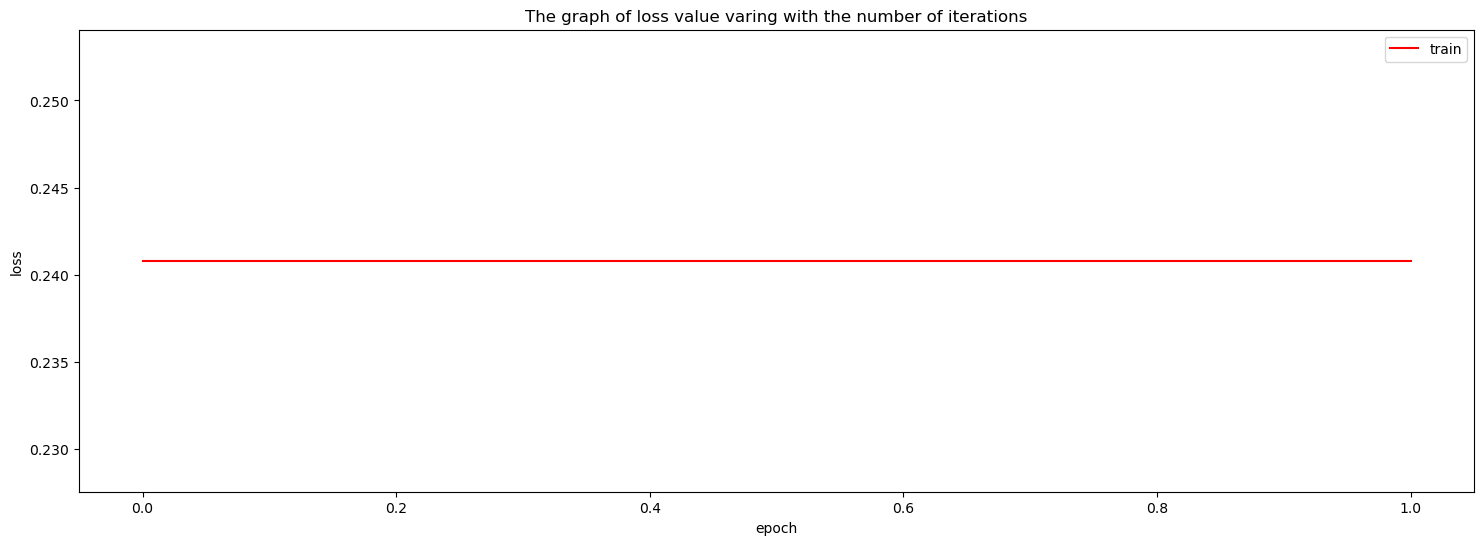

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 6))
plt.plot(losses_train_MASHA, color="r", label="train")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("The graph of loss value varing with the number of iterations")
plt.savefig('./figures/SVM.png')
plt.show()

# DIANA

In [7]:
#max_epoch = 10000  #最大迭代次数

alpha = learning_rate

C = 0.5
m,n = np.shape(X_train)
#tau = 0.3
z = z_init 
w = z

number_of_machines = 5
batch_size = int(np.ceil(m/number_of_machines))
m, n, batch_size

losses_train_DIANA = []#[lmbd * np.sum(z * z) + C * np.sum(np.log(np.abs(1 - Y_train * np.dot(X_train, z))))]
losses_val_DIANA = []
data_sent_DIANA = []#[0]

h = {}
for i in range(number_of_machines):
    h[i] = np.random.random((n_features + 1, 1)) 

In [8]:
#DIANA
Delta = {}
gcap = {}
g = {}
data_sent = 0
for epoch in tqdm(range(max_epoch)):
    
    
    for machine_num in range(number_of_machines):
        index_arr = list(range(machine_num* batch_size, min((machine_num+1)*batch_size,X_train.shape[0])))
        X_train_batch=np.array([X_train[i] for i in index_arr])
        Y_train_batch=[Y_train[i] for i in index_arr]

        g[machine_num] = Fm(w, X_train, Y_train)

        Delta[machine_num] = randk_compress(g[machine_num]- h[machine_num])

        gcap[machine_num] = h[machine_num] + Delta[machine_num]
        h[machine_num] = h[machine_num] + alpha * Delta[machine_num]
        
        data_sent+=Delta[machine_num].shape[0]
        data_sent += h[machine_num].shape[0]

    q = 1/number_of_machines * sum(Delta.values())
    gcap_united = 1/number_of_machines * sum(gcap.values())

    z = (z-learning_rate * gcap_united)/(1+learning_rate)

    loss_train = np.sum(Y_train * np.dot(X_train, z)>0)
    #loss_train = (lmbd * np.sum(z * z) + C * np.sum(np.log(np.abs(1 - Y_train * np.dot(X_train, z)))))
    loss_train = np.mean(Y_train * np.dot(X_train, z)>0)
    #loss_train = (lmbd * np.sum(z * z) + C * np.sum(np.log(np.abs(1 - Y_train * np.dot(X_train, z)))))
    losses_train_DIANA.append(loss_train)# / Y_train.size)

    
    data_sent_DIANA.append(data_sent)

100%|██████████| 2/2 [00:00<00:00,  6.42it/s]


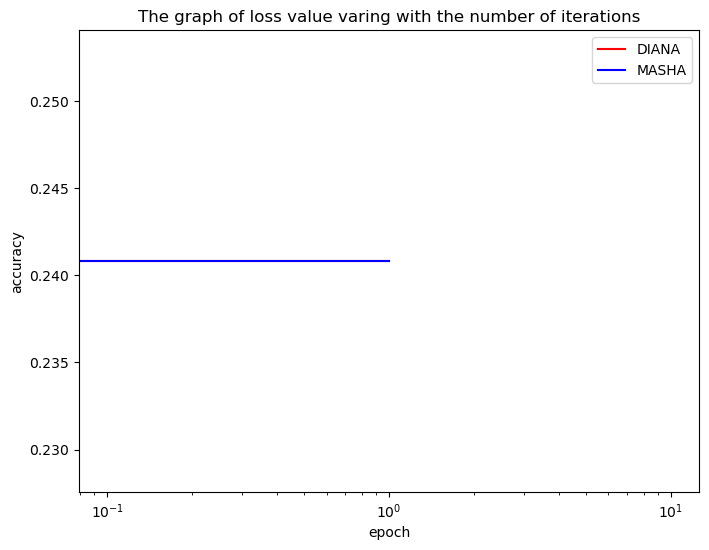

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(losses_train_DIANA, color="r", label="DIANA")
plt.plot(losses_train_MASHA, color="b", label="MASHA")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("The graph of loss value varing with the number of iterations")
plt.semilogx()
plt.savefig('./figures/a9a_by_iteration.pdf')
plt.xscale("log")
plt.show()

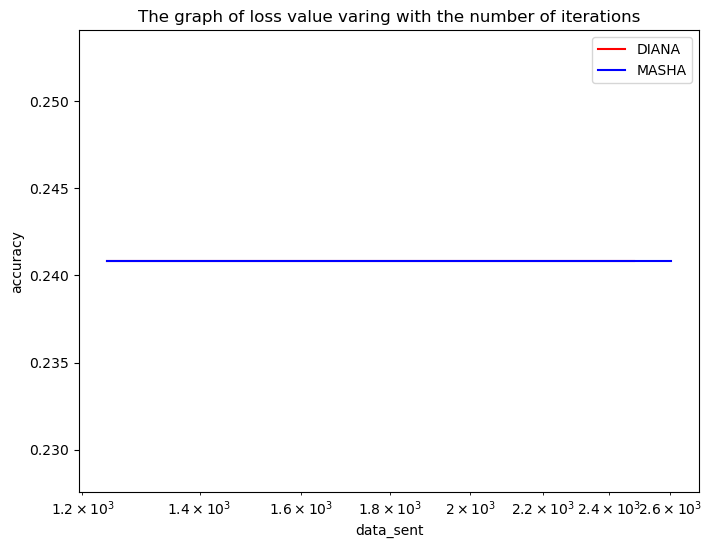

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(data_sent_DIANA, losses_train_DIANA, color="r", label="DIANA", linestyle='-')
plt.plot(data_sent_MASHA, losses_train_MASHA, color="b", label="MASHA", linestyle='-')

plt.legend()
plt.xlabel("data_sent")
plt.ylabel("accuracy")
plt.title("The graph of loss value varing with the number of iterations")
plt.semilogx()
plt.savefig('./figures/a9a_by_data.pdf')
plt.xscale("log")
plt.show()

# EG DIANA (work in progress)

In [13]:
learning_rate = 0.00001  #学习速率
alpha = learning_rate

C = 0.5
m,n = np.shape(X_train)
tau = 0.3
z = z_init
w = 1/24
betta = 0.5

number_of_machines = 5
batch_size = int(np.ceil(m/number_of_machines))
m, n, batch_size

losses_train_EGDIANA = []#[lmbd * np.sum(z * z) + C * np.sum(np.log(np.abs(1 - Y_train * np.dot(X_train, z))))]
losses_val_EGDIANA = []
data_sent_EGDIANA = []#[0]

h_united = np.zeros(n_features + 1) 
h = {}
for i in range(number_of_machines):
    h[i] = h_united

In [21]:
Deltacap = {}
g = {}
data_sent = 0
for epoch in tqdm(range(max_epoch)):
    z_ = z- learning_rate * h_united 
    data_sent += len(z_)*number_of_machines
    for machine_num in range(number_of_machines):
        index_arr = list(range(machine_num* batch_size, min((machine_num+1)*batch_size,X_train.shape[0])))
        X_train_batch=np.array([X_train[i] for i in index_arr])
        Y_train_batch=[Y_train[i] for i in index_arr]

        Delta = Fm(z_, X_train_batch, Y_train_batch) - h[machine_num]
        Deltacap[machine_num] = randk_compress(Delta)
        g[machine_num] = h[machine_num] + Deltacap[machine_num]
        h[machine_num] = h[machine_num] + betta * Deltacap[machine_num]

    
    print(list(Deltacap.values())[0].shape)
    g_united = h + 1/number_of_machines * sum(Deltacap.values())

    z = z_ - learning_rate * g_united
    h = h + 1/(1+w) * 1/number_of_machines * sum(Deltacap.values)
    #y_predict_train = np.where(np.dot(X_train, z) > 0, 1, -1)
    loss_train = (lmbd * np.sum(z * z) + C * np.sum(np.log(np.abs(1 - Y_train * np.dot(X_train, z)))))
    losses_train_EGDIANA.append(loss_train / Y_train.size)

    #y_predict_val = np.where(np.dot(X_test, z) > 0, 1, -1)
    loss_train = np.mean(Y_train * np.dot(X_train, z)>0)
    #loss_train = (lmbd * np.sum(z * z) + C * np.sum(np.log(np.abs(1 - Y_train * np.dot(X_train, z)))))
    losses_train_EGDIANA.append(loss_train)# / Y_train.size)
    
    data_sent_EGDIANA.append(data_sent)



  0%|          | 0/2 [00:00<?, ?it/s]

(124, 124)


TypeError: unsupported operand type(s) for +: 'dict' and 'float'

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 6))
plt.plot(losses_train_EGDIANA, color="r", label="EG_DIANA")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("The graph of loss value varing with the number of iterations")
plt.savefig('./figures/SVM.png')
plt.show()

In [ ]:
learning_rate = 0.00001  #学习速率
alpha = learning_rate

C = 0.5
m,n = np.shape(X_train)
z = z_init
w = 1/24
betta = 0.5

number_of_machines = 5
batch_size = int(np.ceil(m/number_of_machines))
m, n, batch_size

losses_train_EGDIANA = []#[lmbd * np.sum(z * z) + C * np.sum(np.log(np.abs(1 - Y_train * np.dot(X_train, z))))]
losses_val_EGDIANA = []
data_sent_EGDIANA = []#[0]

h_united = z = np.zeros(n_features + 1) 
h = {}
for i in range(number_of_machines):
    h[i] = h_united

In [ ]:
Deltacap = {}
g = {}
data_sent = 0
for epoch in tqdm(range(max_epoch)):
    z_ = z- learning_rate * h_united 
    data_sent += len(z_)*number_of_machines
    for machine_num in range(number_of_machines):
        index_arr = list(range(machine_num* batch_size, min((machine_num+1)*batch_size,X_train.shape[0])))
        X_train_batch=np.array([X_train[i] for i in index_arr])
        Y_train_batch=[Y_train[i] for i in index_arr]

        Delta = Fm(z_, X_train_batch, Y_train_batch) - h[machine_num]
        Deltacap[machine_num] = randk_compress(Delta)
        g[machine_num] = h[machine_num] + Deltacap[machine_num]
        h[machine_num] += betta + Deltacap[machine_num]

    

    g_united = h + 1/number_of_machines * sum(Deltacap.values)

    z = z_ - learning_rate * g_united
    h = h + 1/(1+w) * 1/number_of_machines * sum(Deltacap.values)
    #y_predict_train = np.where(np.dot(X_train, z) > 0, 1, -1)
    loss_train = (lmbd * np.sum(z * z) + C * np.sum(np.log(np.abs(1 - Y_train * np.dot(X_train, z)))))
    losses_train_EGDIANA.append(loss_train / Y_train.size)

    #y_predict_val = np.where(np.dot(X_test, z) > 0, 1, -1)
    loss_train = np.mean(Y_train * np.dot(X_train, z)>0)
    #loss_train = (lmbd * np.sum(z * z) + C * np.sum(np.log(np.abs(1 - Y_train * np.dot(X_train, z)))))
    losses_train_EGDIANA.append(loss_train)# / Y_train.size)
    
    data_sent_EGDIANA.append(data_sent)



